In [2]:
import pandas as pd
import numpy as np
import json
import gdown
import re
from tqdm import tqdm

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn')
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

from collections import Counter

In [14]:
# !gdown 'https://drive.google.com/uc?id=1sqD2c_YyIdnuS7jgHyW_a9c_DC8KhXoV'

Downloading...
From: https://drive.google.com/uc?id=1sqD2c_YyIdnuS7jgHyW_a9c_DC8KhXoV
To: /home/sergey/Documents/Neyro_sets/AIIJC/EduRu/aiijc_comand_data.json
132MB [00:11, 11.9MB/s] 


## Upload data

In [4]:
with open('aiijc_comand_data.json', 'r') as f :
  data = json.load(f)
  allTexts = data['texts']
  allLinks = data['links']

In [5]:
data = pd.read_csv('marked_test.csv')
del data['Unnamed: 0']
data.head()

,task,ans
0,Вопрос 1 Денис готовится провести соревнования...,спорт
1,Реши задачу.\nСколько коробок корма для собак ...,животные
2,"Если групп элементов несколько, то применяется...",спорт
3,Вопрос1 ...,животные
4,Для наглядной геометрической иллюстрации объём...,спорт


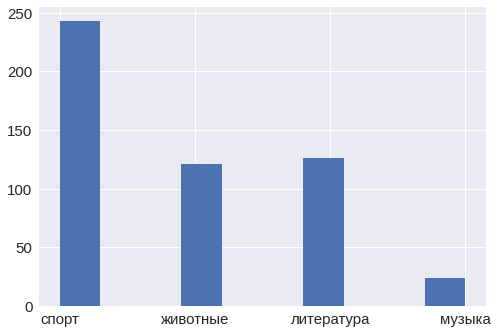

In [184]:
plt.hist(data['ans'])
plt.show()

## Train tf-idf

In [175]:
import importlib
importlib.reload(lg)

[nltk_data] Downloading package stopwords to /home/sergey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sergey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sergey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<module 'logistic_regression' from '/home/sergey/Documents/Neyro_sets/AIIJC/EduRu/logistic_regression.py'>

In [176]:
import sys
sys.path.append('/home/sergey/Documents/Neyro_sets/AIIJC/EduRu')

import logistic_regression as lg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [177]:
preparator = lg.LogicticRegressionPreparator()
y = data['ans'].values
X_text = preparator.prepare_texts(data['task'].values)

100%|████████████████████████████| 514/514 [00:05<00:00, 88.51it/s]


In [178]:
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42)

print(len(X_train), len(X_test))


411 103


In [179]:
model = lg.LogicticRegressionModel(False)
model.fit(X_train , y_train)

[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
iter   6  #CD cycles 3
iter   7  #CD cycles 1
iter   8  #CD cycles 16
iter   9  #CD cycles 3
iter  10  #CD cycles 1
iter  11  #CD cycles 11
iter  12  #CD cycles 1
iter  13  #CD cycles 15
iter  14  #CD cycles 1
iter  15  #CD cycles 18
optimization finished, #iter = 15
Objective value = 1174.888273
#nonzeros/#features = 109/3758
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 6
iter   6  #CD cycles 3
iter   7  #CD cycles 1
iter   8  #CD cycles 17
iter   9  #CD cycles 5
iter  10  #CD cycles 1
iter  11  #CD cycles 18
iter  12  #CD cycles 7
iter  13  #CD cycles 1
iter  14  #CD cycles 20
iter  15  #CD cycles 5
iter  16  #CD cycles 1
iter  17  #CD cycles 18
optimization finished, #iter = 17
Objective value = 1192.683749
#nonzeros/#features = 143/3758
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3 

In [184]:
predict = model.predict(X_test)
print('accuraccy ', accuracy_score(y_test, predict))

accuraccy  0.7087378640776699


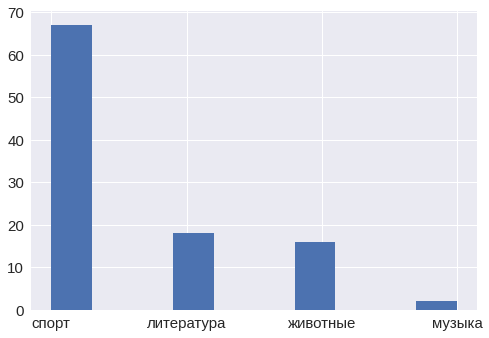

In [181]:
plt.hist(predict)
plt.show()

In [182]:
model.save()

## Find good texts

In [31]:
pattern = {'zadachi1.txt' : r'[0-9]+\.[0-9]+',
           'zadachi2.txt' : r'[0-9]+\.',
           'zadachi2.5.txt' : r'[0-9]+\.',
           'zadachi3.txt' : r'[0-9]+\.[0-9]+\.',
           'zadachi5.txt' : r'№[0-9]+',
          }

In [32]:
tasks = []
for filename, pat in pattern.items() :
    texts = open('data_zadachi/{}'.format(filename), encoding = 'utf-8').read().split('\n') #cp1251
    
    for el in texts :
        if not re.search(pat, el) is None and len(el) > 50 :
            tasks.append(el)

In [33]:
len(tasks)

1927

### Naive bayes predicts

In [ ]:
import sys
sys.path.append('/home/sergey/Documents/Neyro_sets/AIIJC/EduRu/Lisa')
import naive_bayes as nb

In [34]:
tasks_df = pd.DataFrame(tasks, columns = ['texts'])

In [147]:
preparator = nb.Preparator(stopwords_path='Lisa/all_stopwords.txt',
                        bigram_model_path='Lisa/bigram_model.pkl')

nb_model = nb.BayesModel(vect_path='Lisa/nb_vect.sav', 
                         tfidf_path='Lisa/nb_tfidf.sav',
                         clf_path='Lisa/nb_clf.sav',
                        )

X_test = preparator.prepare_texts(tasks_df['texts'].values)

In [148]:
tasks_df['prediction'] = nb_model.predict(X_test)
tasks_df['score'] = nb_model.predict_proba(X_test).max(axis=1)

In [149]:
tasks_df['prediction'] = [nb_model.classes[x] for x in tasks_df['prediction']]

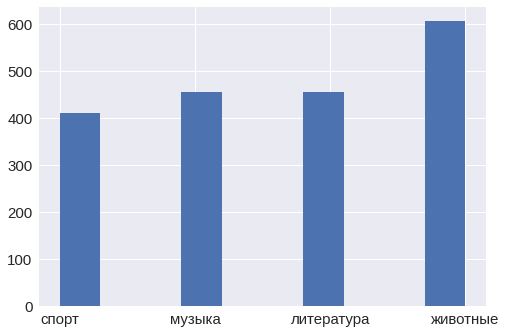

In [150]:
plt.hist(tasks_df['prediction'])
plt.show()

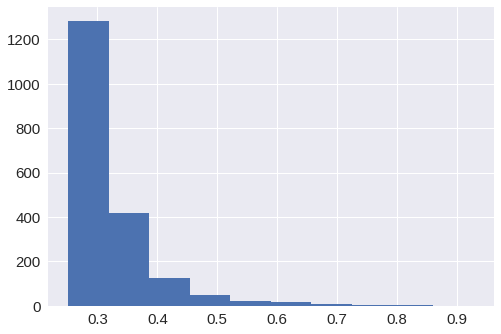

In [151]:
plt.hist(tasks_df['score'])
plt.show()

In [55]:
good_df = tasks_df.copy()

### Saving

In [97]:
# add_df[add_df['score'] < 0.70].to_csv('unknown_dataset.csv')

In [68]:
good_df[good_df['score']>0.3].to_csv('good_additional_dataset.csv')

In [199]:
good_df.to_csv('additional_dataset.csv')

In [56]:
import random
add = good_df[good_df['score'] > 0.4].to_dict('records') # T.to_dict().values()
for i in range(10) :
    print(add[random.randint(0, len(add) - 1)])

{'texts': '9.16. Лестница у Петровской башни имеет 18 ступеней, что на 8 ступеней меньше, чем у Благовещенской. Сколько ступеней у Благовещенской башни?', 'x': 'лестница петровский башня ступень ступень благовещенский ступень благовещенский башня', 'prediction': 'музыка', 'score': 0.4303619157955795}
{'texts': '\t15.27*. Из 21 м ткани получаются 5 одинаковых платьев. Сколько платьев получится из 42 м такой ткани?', 'x': 'ткань ткань', 'prediction': 'животные', 'score': 0.41893767585288666}
{'texts': '6.16. Две книги стоят 47 руб., одна из них – 30 руб. Сколько стоит вторая книга?', 'x': 'книга стоять книга', 'prediction': 'литература', 'score': 0.46132872400605307}
{'texts': '\t10.14. В кабинете биологии 6 гербариев с листьями растений по 10 листьев в каждом и 8 гербариев цветов по 9 штук в каждом. Сколько всего экспонатов растений в кабинете биологии?', 'x': 'кабинет биология гербарий лист растение лист гербарий цвет штука экспонат растение кабинет биология', 'prediction': 'животные',